# Analyze Life Expectancy Data 

## Project Description
The goal of the project is to analyze Global Health Observatory (GHO) data from World Health Organization (WHO), create a model to predict life expectancy and provide recommendations to increase life expectancy.

## Goals: 
   - find features relation with life expectancy
   - create a model to predict life expectancy
   - provide recommendations to raise life expectancy

In [1]:
# imports 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import wrangle as w
import modeling as m

import warnings
warnings.filterwarnings("ignore")

seed = 42

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Acquire

- Acquired data from website of databank and WHO.
- It contains 1808 rows and 15 columns. 
- Each row represents a country.
- Each column represents a features of a country.


In [2]:
# acquire data using a function from wrangle module
df = w. acquire_data()

# peak into data
df.head()

,country,year,life_expectancy,life_expectancey_male,life_expectancey_female,infant_deaths,under_five_deaths,traffic_deaths,diphtheria,hepatitis_B,measles,population,GDP,percentage_expenditure,income_group
0,Afghanistan,2020.0,62.575,59.866,65.432,45,58,..,70,70,66,38972230.0,516.866552182696,15.53,Low income
1,Afghanistan,2019.0,63.565,60.619,66.677,46.4,60.1,15.9,72,72,64,37769499.0,500.522664145294,14.83,Low income
2,Afghanistan,2018.0,63.081,59.923,66.458,47.9,62.3,14.2,72,72,71,36686784.0,502.056770622973,14.21,Low income
3,Afghanistan,2017.0,63.016,60.105,66.099,49.5,64.8,15.1,66,66,67,35643418.0,530.149830802984,12.62,Low income
4,Afghanistan,2016.0,63.136,61.193,65.096,51.3,67.5,14.8,66,66,64,34636207.0,520.252064031151,11.82,Low income


## Prepare

#### Prepare Actions:

- Rename column names.
- Drop unwanted columns.
- Merge dataframes.
- Check for Nulls,use forward fill and back fill to fill Nulls.
- Split data into train, validate and test (approx. 56/24/20)

In [3]:
# acquire data, clean data, and split data using a function from wrangle module
train, validate, test = w.wrangle_data()

## Explore

### Do countries income determine life expectancy?

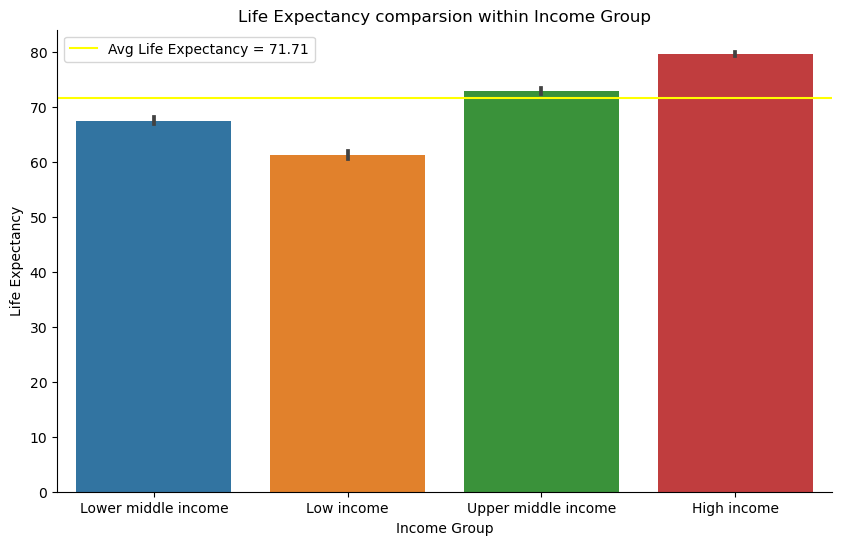

In [4]:
m.viz_barplot(train)

<div class="alert alert-block alert-warning">
<b>TakeAways:</b> 
    
From graph, we can see that countries with low income have lower life expecatncy than countries with high income.
</div>


### Do infant deaths occur more in low income countries?

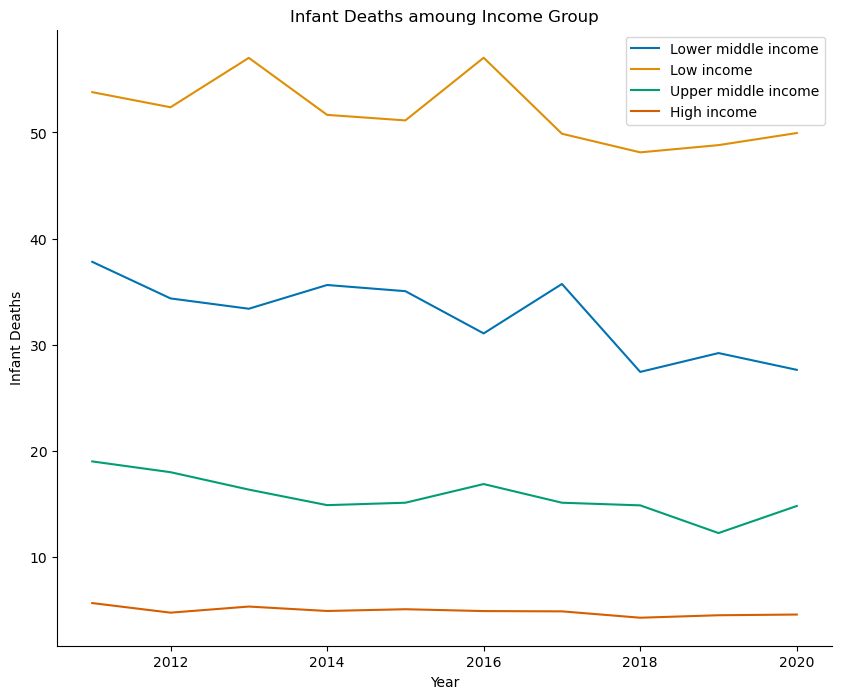

In [5]:
m.viz_lineplot(train)

<div class="alert alert-block alert-warning">
<b>TakeAways:</b> 
    
From graph, we can see that infant deaths has decreased over 2011-2020 for all income group countries. Super rich  countries have lowest infant deaths and its trend is flat. Poor countries have spikes on infant deaths on certain years. Upper middle income countries infant deaths spikedbetween 2019 and 2020 while other countires have steady trends.


### Immunization relations with death of under five old

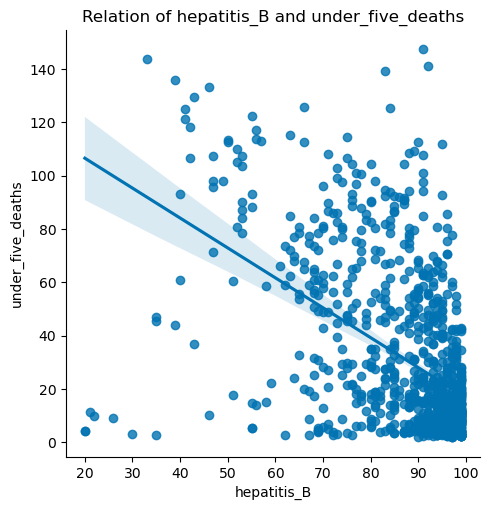

In [6]:
m.viz_lmplot(train, 'hepatitis_B', 'under_five_deaths')

In [7]:
m.pearson_test(train,'hepatitis_B','under_five_deaths')

p is 0.0000000000, -0.4991485345547424
The pearson r test shows that there is a relationship.


<div class="alert alert-block alert-warning">
<b>TakeAways:</b> 
    
From graph, we can see that immunizaiton of hepatits B and death of under five have negtive relationship.
    
Pearson r test shows that there is negative relationship between immunizaiton of hepatitis B and death of childern under five.


### What is the relation of percentage of expenditure and life expectancy?

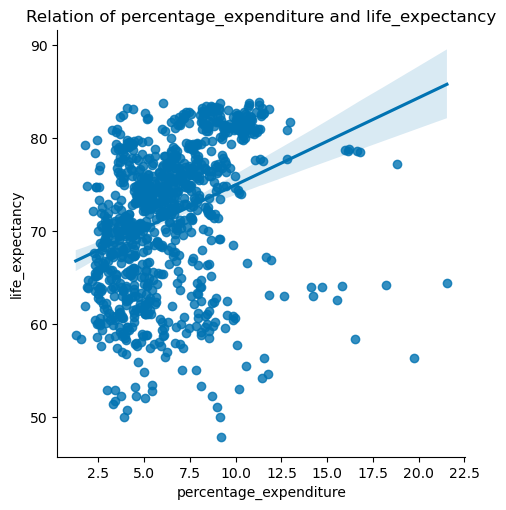

In [8]:
m.viz_lmplot(train, 'percentage_expenditure', 'life_expectancy')

In [9]:
m.pearson_test(train,'percentage_expenditure','life_expectancy')

p is 0.0000000000, 0.3325907793780053
The pearson r test shows that there is a relationship.


<div class="alert alert-block alert-warning">
<b>TakeAways:</b> 
    
From graph, we can see that percentage of expediture of GDP on health  has 
positive correlation with life expectancy.
    
Pearson r test shows that there is a significant positive relationship.

### What is the relation of GDP and life expectancy?

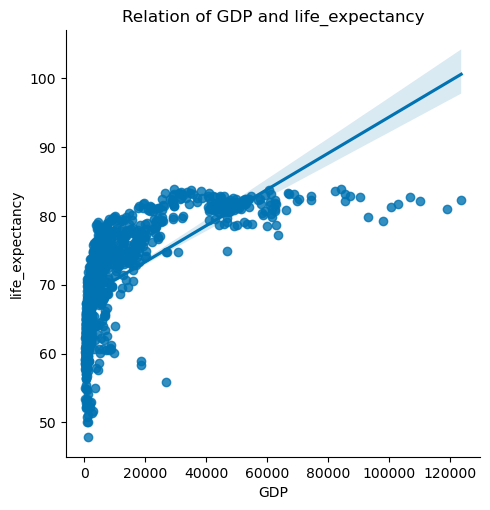

In [10]:
m.viz_lmplot(train, 'GDP', 'life_expectancy')

In [11]:
m.pearson_test(train,'GDP','life_expectancy')

p is 0.0000000000, 0.6450357586557457
The pearson r test shows that there is a relationship.


<div class="alert alert-block alert-warning">
<b>TakeAways:</b> 
    
From graph, we can see that GDP and life expectancy has positive correlationship.
    
Pearson r test shows that there is a significant positive relationship.

### Exploration Summary:
- GDP, immunizations and  percentage expendiutre on health have positive coorrelation with life expectancy.
- Infant deaths, deaths of under five and traffic deaths have negative correlation with life expectancy.
- Poor countries have life expenctancy below average life expectancy of 71.71 whereas rich coutries have life  expectancy above average life expectancy.
- Poor countries have higher infant deaths. 
- I will use GDP, immunizations, percentage expendiutrenfant, infant deaths, deaths of under five, and traffic deaths for model because all of them have significant realtionship with life expectancy.

### Scale Data:
- I used MinMax Scaler to scale data.


In [12]:
# scale data
train_scaled, validate_scaled, test_scaled= m.scale_data(train, validate, test, 
                                                       columns_to_scale=['life_expectancey_male','life_expectancey_female', 'infant_deaths', 
                                 'under_five_deaths','traffic_deaths', 'diphtheria', 'hepatitis_B', 
                                 'measles', 'population','GDP', 'percentage_expenditure', 
                                 'High income','Low income', 'Lower middle income', 'Upper middle income']
                                                         ,return_scaler=False)

## Modeling

- I will use train data and validate data on different models to get the model that performs the best.Then, I will use the test data on the best model to get predicitons.
- I will use my baseline RMSE as my evaluation metric.
- I will use following four modelsto get the best model:
    - Model 1: Linear Regression(OLS)
    - Model 2: LASSOLARS
    - Model 3: TweedieRegressor
    - Model 4: Polynomial Regression

In [13]:
# split into target and features
X_train, y_train, X_validate, y_validate, X_test, y_test = m.X_y_split(train_scaled, validate_scaled, test_scaled, 'life_expectancy')

### Baseline RMSE

In [14]:
# get RMSE on train and validate data using mean from function of modelling module
m.print_rmse_baseline(train,validate,'life_expectancy')

RMSE using mean: 
train_RMSE: 7.700198332689784
validate RMSE: 7.866369962044724


<div class="alert alert-block alert-warning">

    
Baseline RMSE: 7.7

In [15]:
# get a dataframe showing RMSE of models
rmse_df= m.rmse_models(X_train,y_train,X_validate,y_validate,train, validate, 'life_expectancy')
rmse_df

,train_RMSE,validate_RMSE,difference
baseline,7.700198,7.86637,-0.166172
LinearRegreesion,2.310000,2.69000,-0.380000
LassoLars(alpha=1),5.360000,5.55000,-0.190000
"TweedieRegreesor(power=1, alpha=0)",2.270000,2.64000,-0.370000
Polynomial Regression(degree=3),2.310000,2.69000,-0.380000


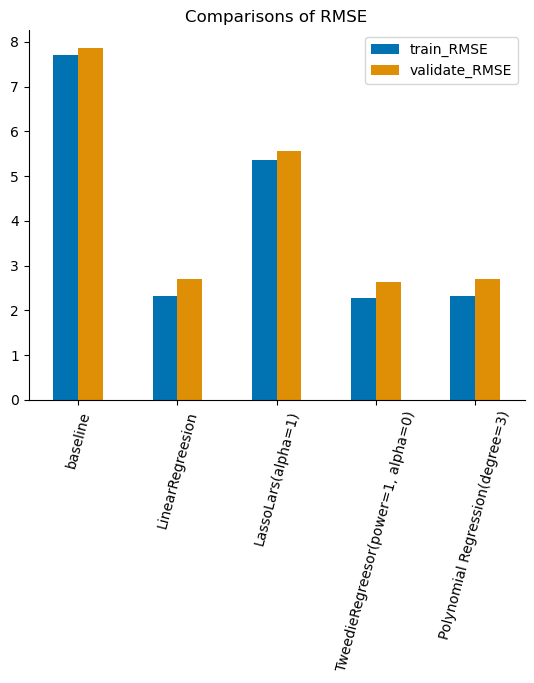

In [16]:
m.plot_rmse(rmse_df)

### Model Evaluation

In [17]:
m.tweedie_test(X_train, y_train, X_test, y_test, 'life_expectancy', 1, 0)

Using tweedie on test
RMSE : 2.43
r2 : 0.9200933643847337


<div class="alert alert-block alert-warning">
<b>TakeAways:</b> 
   
The Tweedie Regression performed with RMSE 2.43 on test data beating the baseline RMSE of 7.7.

### Modelling summary
- All models perfomed better than baseline on train and validat data.
- All models perfomed worse on validate to train.
- Tweedie Regression with power 1 and alpha 0 performed better than other models with RMSE 2.43 on test data beating the baseline RMSE of 7.7.


## Conclusions 

- GDP, immunizations, and percentage expendiutre on health have positive coorrelation with life expectancy.
- Infant deaths, deaths of under five, and traffic deaths have negative correlation with life expectancy.
- Poor countries have life expenctancy below average life expectancy of 71.71 whereas rich coutries have life  expectancy above average life expectancy.
- Poor countries have higher infant deaths. 
- All models perfomed better than baseline on train and validat data.
- All models perfomed worse on validate to train.
- Tweedie Regression with power 1 and alpha 0 performed better than other models.
- The Tweedie Regression performed with RMSE 2.43 on test data beating the baseline RMSE of 7.7.

###  Recommendations and Next Steps
 - recommend low income countries to run program to decrease infant deaths. There is higher number of infant deaths. 
 - recommend to increase in expenses for health to increase life expectancy.
 
 - I will exlpore further by location to see if geography and temparature affect life expectancy.